[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/okada-tak/deep-learning-from-scratch-2/blob/master/notebooks/ch05.ipynb)

# 5章 リカレントニューラルネットワーク(RNN) のまとめ
- RNNはループする経路があり、それによって「隠れ状態」を内部に記憶することができる
- RNNのループ経路を展開することで、複数のRNNレイヤがつながったネットワークと解釈することができ、通常の誤差逆伝播法によって学習することができる（＝BPTT）
- 長い時系列データを学習する場合は、適当な長さでデータのまとまりを作り－これを「ブロック」という－、ブロック単位でBPTTによる学習を行う（＝Truncated BPTT）
- Truncated BPTTでは逆伝播のつながりのみを切断する
- Truncated BPTTでは順伝播のつながりは維持するため、データは”シーケンシャル”に与える必要がある
- 言語モデルは、単語の羅列を確率として解釈する
- RNNレイヤを利用した条件付き言語モデルは、（理論的には）それまで登場した単語の情報を記憶することができる

単純なフィードフォワード・ネットワークでは、時系列データの性質（パターン）を十分に学習することができない

## 5.1 確率と言語モデル

### 5.1.1 word2vecを確率の視点から眺める
$w_{t-1}$と$w_{t+1}$が与えられたとき、ターゲットが$w_t$となる確率  
$$
P(w_t|w_{t-1}, w_{t+1})
$$

左側2つの単語だけをコンテキストとして考える
$$
P(w_t|w_{t-2}, w_{t-1})
$$

CBOWモデルが扱う損失関数
$$
L=-logP(w_t|w_{t-2}, w_{t-1})
$$

### 5.1.2 言語モデル
$w_1$,…,$w_m$の$m$個の単語からなる文章  
$w_1$,…,$w_m$という順序で単語が出現する確率  
$$
\begin{split}
P(w_1,…,w_m)&=P(w_m|w_1,…,w_{m-1})P(w_{m-1}|w_1,…,w_{m-2})...P(w_3|w_1,w_2)P(w_2|w_1)p(w_1)\\  
&=\prod_{t=1}^mP(w_t|w_1,…,w_{t-1})
\end{split}
$$
目標：  
$P(w_t|w_1,…,w_{t-1})$を求めること。これがわかれば言語モデルの同時確率$P(w_1,…,w_m)$を求められる

### 5.1.3 CBOWモデルを言語モデルに？
コンテキストのサイズを限定することでCBOWモデルを言語モデルに適用
$$
P(w_1,…,w_m)=\prod_{t=1}^mP(w_t|w_1,…,w_{t-1})≈\prod_{t=1}^mP(w_t|w_{t-2},w_{t-1})
$$
直前の2つの単語だけに依存するとして2階のマルコフ連鎖  
CBOWモデルではコンテキスト内の単語の並びが無視されるのが問題


## 5.2 RNNとは

### 5.2.1 循環するニューラルネットワーク
### 5.2.2 ループの展開
$$
\mathbf h_t=tanh(\mathbf h_{t-1}\mathbf W_\mathbf h+\mathbf x_t\mathbf W_\mathbf x+\mathbf b)
$$

### 5.2.3 Backpropagation Through Time
長い時系列データを扱うと消費する計算リソースが増大する  
逆伝播時の勾配が不安定になる

### 5.2.4 Truncated BPTT
ネットワークの逆伝播のつながりだけを適当な長さで切り取り、切り取られたネットワーク単位で学習する

順伝播のつながりは切断しないのでデータをシーケンシャルに与える必要がある

### 5.2.5 Truncated BPTTのミニバッチ学習
データの与え方：

*   データをシーケンシャルに与えること
*   各バッチでデータを与える開始位置をずらすこと



## 5.3 RNNの実装
RNNの1ステップの処理を行うクラスをRNNクラス

そのRNNクラスを利用して、Tステップの処理をまとめて行うレイヤをTimeRNNクラス

### 5.3.1 RNNレイヤの実装
RNNの順伝播  
$$
\mathbf h_t=tanh(\mathbf h_{t-1}\mathbf W_\mathbf h+\mathbf x_t\mathbf W_\mathbf x+\mathbf b)
$$

## ■Colaboratory用
Google Colaboratoryの場合、Google Driveに  
dl-from-scratch-2/ch05  
というフォルダを用意し、そこにこのjupyter notebookを配置。  
(dl-from-scratch-2の部分は任意。)  
また、datasetフォルダとcommonフォルダを
dl-from-scratch-2/dataset  
dl-from-scratch-2/common
にコピーしておく。  

以下のセルでGoogle Driveをマウント。許可を求められるので許可する。

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## ■Colaboratory用
chdirする。

In [2]:
import sys,os
os.chdir('/content/drive/My Drive/dl-from-scratch-2/ch05')
os.getcwd()

'/content/drive/My Drive/dl-from-scratch-2/ch05'

common/time_layers.py

In [ ]:
from common.np import *  # import numpy as np (or import cupy as np)
from common.layers import *
from common.functions import softmax, sigmoid

class RNN:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.cache = None

    def forward(self, x, h_prev):
        Wx, Wh, b = self.params
        t = np.dot(h_prev, Wh) + np.dot(x, Wx) + b
        h_next = np.tanh(t)

        self.cache = (x, h_prev, h_next)
        return h_next

    def backward(self, dh_next):
        Wx, Wh, b = self.params
        x, h_prev, h_next = self.cache

        dt = dh_next * (1 - h_next ** 2)
        db = np.sum(dt, axis=0)
        dWh = np.dot(h_prev.T, dt)
        dh_prev = np.dot(dt, Wh.T)
        dWx = np.dot(x.T, dt)
        dx = np.dot(dt, Wx.T)

        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        return dx, dh_prev

### 5.3.2 Time RNNレイヤの実装


common/time_layers.py

In [ ]:
class TimeRNN:
    def __init__(self, Wx, Wh, b, stateful=False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None

        self.h, self.dh = None, None
        self.stateful = stateful

    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        D, H = Wx.shape

        self.layers = []
        hs = np.empty((N, T, H), dtype='f')

        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')

        for t in range(T):
            layer = RNN(*self.params)
            self.h = layer.forward(xs[:, t, :], self.h)
            hs[:, t, :] = self.h
            self.layers.append(layer)

        return hs

    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, H = dhs.shape
        D, H = Wx.shape

        dxs = np.empty((N, T, D), dtype='f')
        dh = 0
        grads = [0, 0, 0]
        for t in reversed(range(T)):
            layer = self.layers[t]
            dx, dh = layer.backward(dhs[:, t, :] + dh)
            dxs[:, t, :] = dx

            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        self.dh = dh

        return dxs

    def set_state(self, h):
        self.h = h

    def reset_state(self):
        self.h = None

## 5.4 時系列データを扱うレイヤの実装

### 5.4.1 RNNLMの全体図

「you say」という過去の情報をコンパクトな隠れ状態ベクトルとしてRNNが保持している。その情報を上層のAffineレイヤ、および次時刻のRNNレイヤへ伝達する。

### 5.4.2 Timeレイヤの実装
$$
L=\frac{1}{T}(L_0+L_1+…+L_{T-1})
$$

## 5.5 RNNLMの学習と評価

### 5.5.1 RNNLMの実装

ch05/simple_rnnlm.py

In [ ]:
# coding: utf-8
import sys
sys.path.append('..')
import numpy as np
from common.time_layers import *


class SimpleRnnlm:
    def __init__(self, vocab_size, wordvec_size, hidden_size):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # 重みの初期化
        embed_W = (rn(V, D) / 100).astype('f')
        rnn_Wx = (rn(D, H) / np.sqrt(D)).astype('f')
        rnn_Wh = (rn(H, H) / np.sqrt(H)).astype('f')
        rnn_b = np.zeros(H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # レイヤの生成
        self.layers = [
            TimeEmbedding(embed_W),
            TimeRNN(rnn_Wx, rnn_Wh, rnn_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.rnn_layer = self.layers[1]

        # すべての重みと勾配をリストにまとめる
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, xs, ts):
        for layer in self.layers:
            xs = layer.forward(xs)
        loss = self.loss_layer.forward(xs, ts)
        return loss

    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    def reset_state(self):
        self.rnn_layer.reset_state()

初期値はXavierの初期値を使う。

vol.1の「6.2 重みの初期値」参照。

### 5.5.2 言語モデルの評価
言語も出るの予測性能の良さを評価する指標：　パープレキシティ（perplexity）

確率の逆数で、小さいほうがよく、最小値は1.0。

直感的には「分岐数」。次に出現しうる単語の候補の数。

入力データがN個ある場合：

$$
L=-\frac{1}{N}\sum_n \sum_kt_{nk}\log y_{nk}
$$
$$
\text{perplexity}=e^L
$$
$L$はニューラルネットワークの損失。

### 5.5.3 RNNLMの学習コード

ch05/train_custom_loop.py

corpus size: 1000, vocabulary size: 418
| epoch 1 | perplexity 390.00
| epoch 2 | perplexity 267.89
| epoch 3 | perplexity 226.99
| epoch 4 | perplexity 215.82
| epoch 5 | perplexity 207.23
| epoch 6 | perplexity 203.82
| epoch 7 | perplexity 199.74
| epoch 8 | perplexity 197.03
| epoch 9 | perplexity 192.03
| epoch 10 | perplexity 193.34
| epoch 11 | perplexity 189.01
| epoch 12 | perplexity 191.97
| epoch 13 | perplexity 189.92
| epoch 14 | perplexity 189.33
| epoch 15 | perplexity 188.61
| epoch 16 | perplexity 185.94
| epoch 17 | perplexity 184.03
| epoch 18 | perplexity 180.52
| epoch 19 | perplexity 182.11
| epoch 20 | perplexity 183.43
| epoch 21 | perplexity 180.82
| epoch 22 | perplexity 178.46
| epoch 23 | perplexity 174.89
| epoch 24 | perplexity 178.58
| epoch 25 | perplexity 173.45
| epoch 26 | perplexity 174.65
| epoch 27 | perplexity 168.67
| epoch 28 | perplexity 168.02
| epoch 29 | perplexity 165.46
| epoch 30 | perplexity 159.52
| epoch 31 | perplexity 163.14
| epoch 

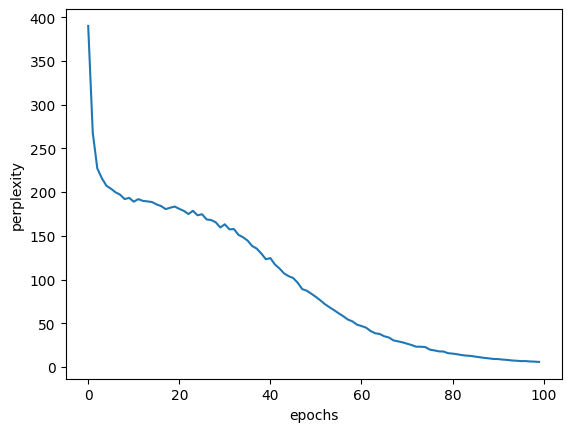

In [3]:
# coding: utf-8
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
from common.optimizer import SGD
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100
time_size = 5  # Truncated BPTTの展開する時間サイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み（データセットを小さくする）
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)

xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）
data_size = len(xs)
print('corpus size: %d, vocabulary size: %d' % (corpus_size, vocab_size))

# 学習時に使用する変数
max_iters = data_size // (batch_size * time_size)
time_idx = 0
total_loss = 0
loss_count = 0
ppl_list = []

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)

# ミニバッチの各サンプルの読み込み開始位置を計算
jump = (corpus_size - 1) // batch_size
offsets = [i * jump for i in range(batch_size)]

for epoch in range(max_epoch):
    for iter in range(max_iters):
        # ミニバッチの取得
        batch_x = np.empty((batch_size, time_size), dtype='i')
        batch_t = np.empty((batch_size, time_size), dtype='i')
        for t in range(time_size):
            for i, offset in enumerate(offsets):
                batch_x[i, t] = xs[(offset + time_idx) % data_size]
                batch_t[i, t] = ts[(offset + time_idx) % data_size]
            time_idx += 1

        # 勾配を求め、パラメータを更新
        loss = model.forward(batch_x, batch_t)
        model.backward()
        optimizer.update(model.params, model.grads)
        total_loss += loss
        loss_count += 1

    # エポックごとにパープレキシティの評価
    ppl = np.exp(total_loss / loss_count)
    print('| epoch %d | perplexity %.2f'
          % (epoch+1, ppl))
    ppl_list.append(float(ppl))
    total_loss, loss_count = 0, 0

# グラフの描画
x = np.arange(len(ppl_list))
plt.plot(x, ppl_list, label='train')
plt.xlabel('epochs')
plt.ylabel('perplexity')
plt.show()

### 5.5.4 RNNLMのTrainerクラス


ch05/train.py

| epoch 1 |  iter 1 / 19 | time 0[s] | perplexity 418.28
| epoch 2 |  iter 1 / 19 | time 0[s] | perplexity 390.53
| epoch 3 |  iter 1 / 19 | time 0[s] | perplexity 279.06
| epoch 4 |  iter 1 / 19 | time 0[s] | perplexity 222.90
| epoch 5 |  iter 1 / 19 | time 0[s] | perplexity 211.05
| epoch 6 |  iter 1 / 19 | time 0[s] | perplexity 209.57
| epoch 7 |  iter 1 / 19 | time 0[s] | perplexity 200.28
| epoch 8 |  iter 1 / 19 | time 0[s] | perplexity 201.23
| epoch 9 |  iter 1 / 19 | time 0[s] | perplexity 194.49
| epoch 10 |  iter 1 / 19 | time 0[s] | perplexity 190.65
| epoch 11 |  iter 1 / 19 | time 0[s] | perplexity 192.18
| epoch 12 |  iter 1 / 19 | time 1[s] | perplexity 188.73
| epoch 13 |  iter 1 / 19 | time 1[s] | perplexity 192.69
| epoch 14 |  iter 1 / 19 | time 1[s] | perplexity 187.31
| epoch 15 |  iter 1 / 19 | time 1[s] | perplexity 186.34
| epoch 16 |  iter 1 / 19 | time 1[s] | perplexity 190.61
| epoch 17 |  iter 1 / 19 | time 1[s] | perplexity 188.60
| epoch 18 |  iter 1 / 

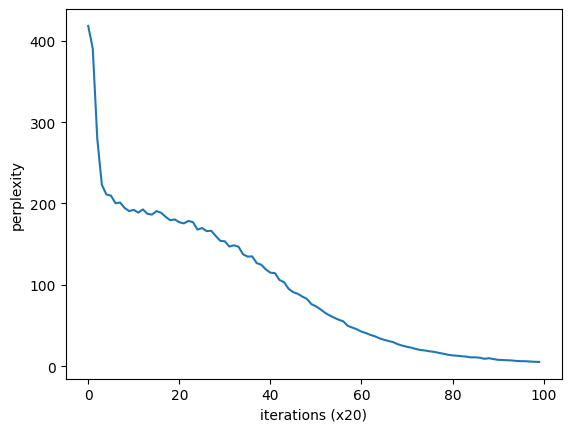

In [4]:
# coding: utf-8
import sys
sys.path.append('..')
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from dataset import ptb
from simple_rnnlm import SimpleRnnlm


# ハイパーパラメータの設定
batch_size = 10
wordvec_size = 100
hidden_size = 100  # RNNの隠れ状態ベクトルの要素数
time_size = 5  # RNNを展開するサイズ
lr = 0.1
max_epoch = 100

# 学習データの読み込み
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_size = 1000  # テスト用にデータセットを小さくする
corpus = corpus[:corpus_size]
vocab_size = int(max(corpus) + 1)
xs = corpus[:-1]  # 入力
ts = corpus[1:]  # 出力（教師ラベル）

# モデルの生成
model = SimpleRnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

trainer.fit(xs, ts, max_epoch, batch_size, time_size)
trainer.plot()

## 5.6 まとめ
